In [65]:
import os
import datetime
import time
from datetime import datetime, timedelta, date
from typing import List

from google.cloud import bigquery
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from IPython.core.display import HTML 

# Pull the data from bigquery table
from google.cloud import bigquery
# Construct a BigQuery client object.
client = bigquery.Client()

from warnings import simplefilter
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from kats.consts import TimeSeriesData

# Setting columns to maximum
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

In [25]:
query = """
     select * from `edna-datastg-pr-cah.D2_ML_MED_CUSTCHRN_NP_EXPM.presourceKitSalesRaw_WEEKLY_FULL`
     WHERE WEEK_START_DATE >= '2020-01-06'
     AND WEEK_START_DATE <= '2021-11-07'
     AND neverOutFlag = 1
"""
query_job = client.query(
    query,
    location="US",
) 
df = query_job.to_dataframe()
df.shape

(74559, 131)

In [26]:
df_kit = df.loc[df['MASTER_NUMBER'] == '01-7228', ['WEEK_START_DATE','UNITS']].sort_values(by = ['WEEK_START_DATE'], ascending = True).reset_index(drop=True)
df_kit

,WEEK_START_DATE,UNITS
0,2020-01-06,20137
1,2020-01-13,20280
2,2020-01-20,19656
3,2020-01-27,19568
4,2020-02-03,21004
...,...,...
91,2021-10-04,20396
92,2021-10-11,21402
93,2021-10-18,21051
94,2021-10-25,20572


In [27]:
df_kit.columns = ['time','value']
df_kit

,time,value
0,2020-01-06,20137
1,2020-01-13,20280
2,2020-01-20,19656
3,2020-01-27,19568
4,2020-02-03,21004
...,...,...
91,2021-10-04,20396
92,2021-10-11,21402
93,2021-10-18,21051
94,2021-10-25,20572


In [28]:
df_kit_ts = TimeSeriesData(df_kit)
print(type(df_kit_ts))
print(type(df_kit_ts.time))

<class 'kats.consts.TimeSeriesData'>
<class 'pandas.core.series.Series'>


# Plotting

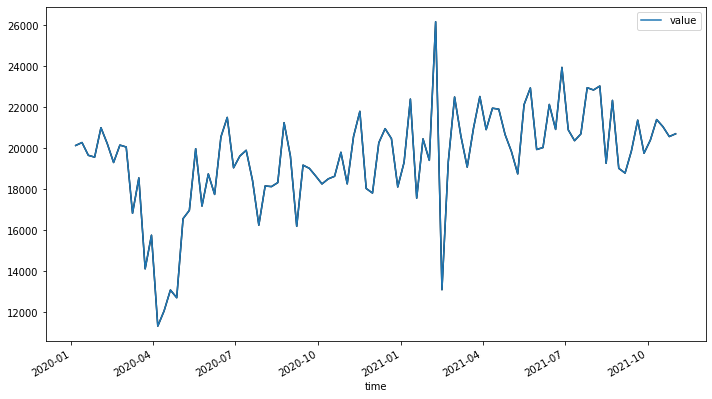

In [29]:
%matplotlib inline

# Must pass the name of the value columns to plot
df_kit_ts.plot(cols=['value'])
plt.show()

In [32]:
# Prophet Model

# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='additive') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(df_kit_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="W")
fcst.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -39.3338
Iteration  1. Log joint probability =    117.957. Improved by 157.291.
Iteration  2. Log joint probability =    141.012. Improved by 23.0552.
Iteration  3. Log joint probability =    178.975. Improved by 37.9632.
Iteration  4. Log joint probability =    189.184. Improved by 10.2083.
Iteration  5. Log joint probability =    189.208. Improved by 0.0238862.
Iteration  6. Log joint probability =    189.225. Improved by 0.0171185.
Iteration  7. Log joint probability =     189.24. Improved by 0.0156735.
Iteration  8. Log joint probability =    189.294. Improved by 0.0537736.
Iteration  9. Log joint probability =    189.297. Improved by 0.00245439.
Iteration 10. Log joint probability =    189.385. Improved by 0.0881728.
Iteration 11. Log joint probability =     189.39. Improved by 0.00485933.
Iteration 12. Log joint probability =      189.4. Improved by 0.0104511.
Iteration 13. Log joint probability =    189.436. Improved by 0.0361234.
Iteration 14. L

,time,fcst,fcst_lower,fcst_upper
0,2021-11-07,21607.300804,18669.240802,24444.596214
1,2021-11-14,21650.869803,18858.052364,24455.686867
2,2021-11-21,21694.438801,18848.034243,24598.506676
3,2021-11-28,21738.007800,18916.914962,24335.241117
4,2021-12-05,21781.576798,18930.272591,24660.552514


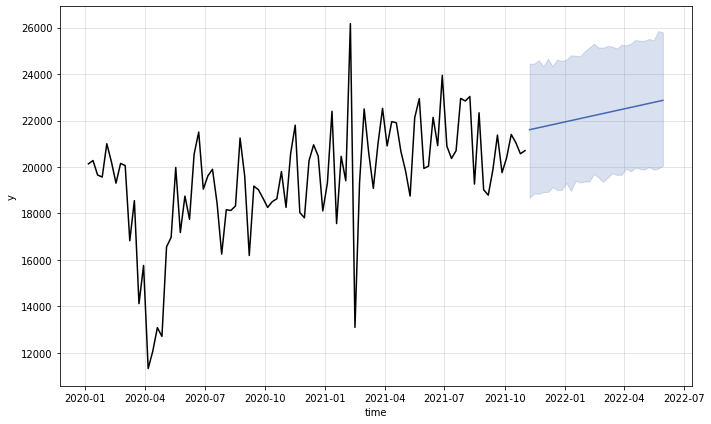

In [33]:
m.plot()

# MultiStep forecast

In [54]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [49]:
df_kit.set_index(
    pd.PeriodIndex(df_kit.time, freq="W"),
    inplace=True,
)
df_kit.drop("time", axis=1, inplace=True)
df_kit.head(2)

,value
time,
2020-01-06/2020-01-12,20137
2020-01-13/2020-01-19,20280


In [58]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = df_kit.value.copy()
X = make_lags(y, lags=26).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=4).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [61]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

<AxesSubplot:xlabel='time'>

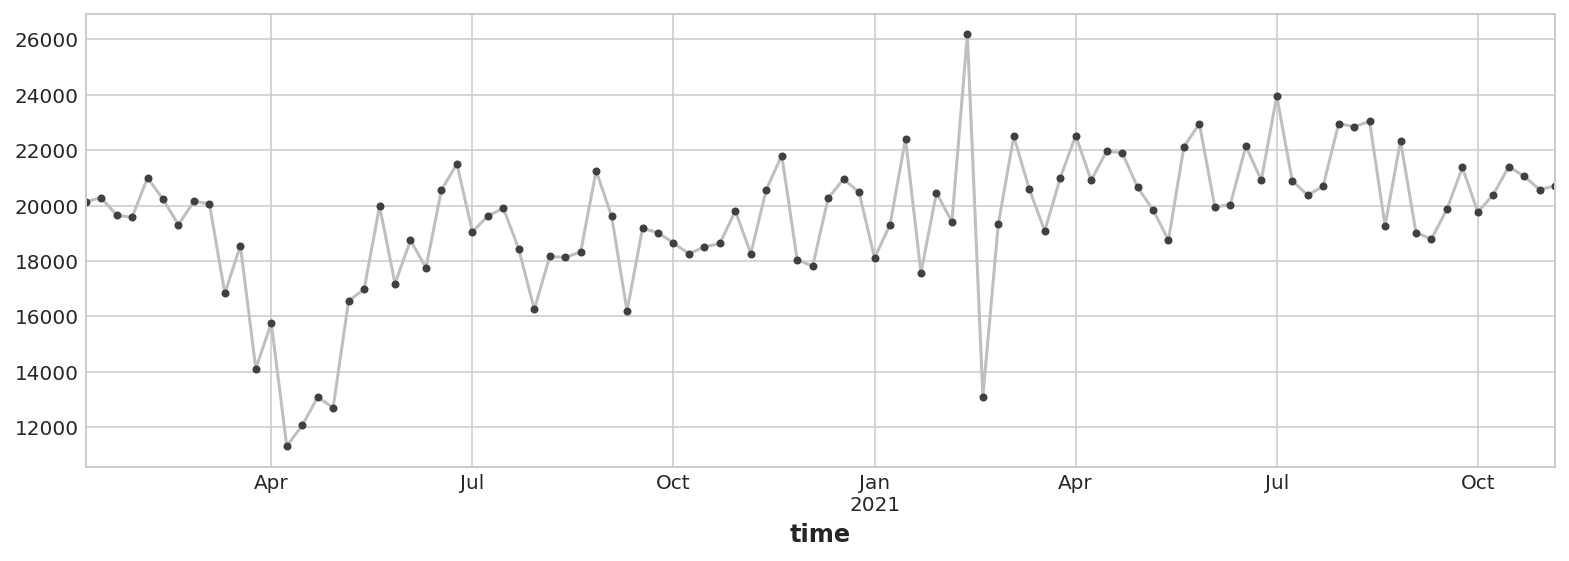

In [55]:
df_kit.value.plot(**plot_params)

Train RMSE: 1474.32
Test RMSE: 2334.21


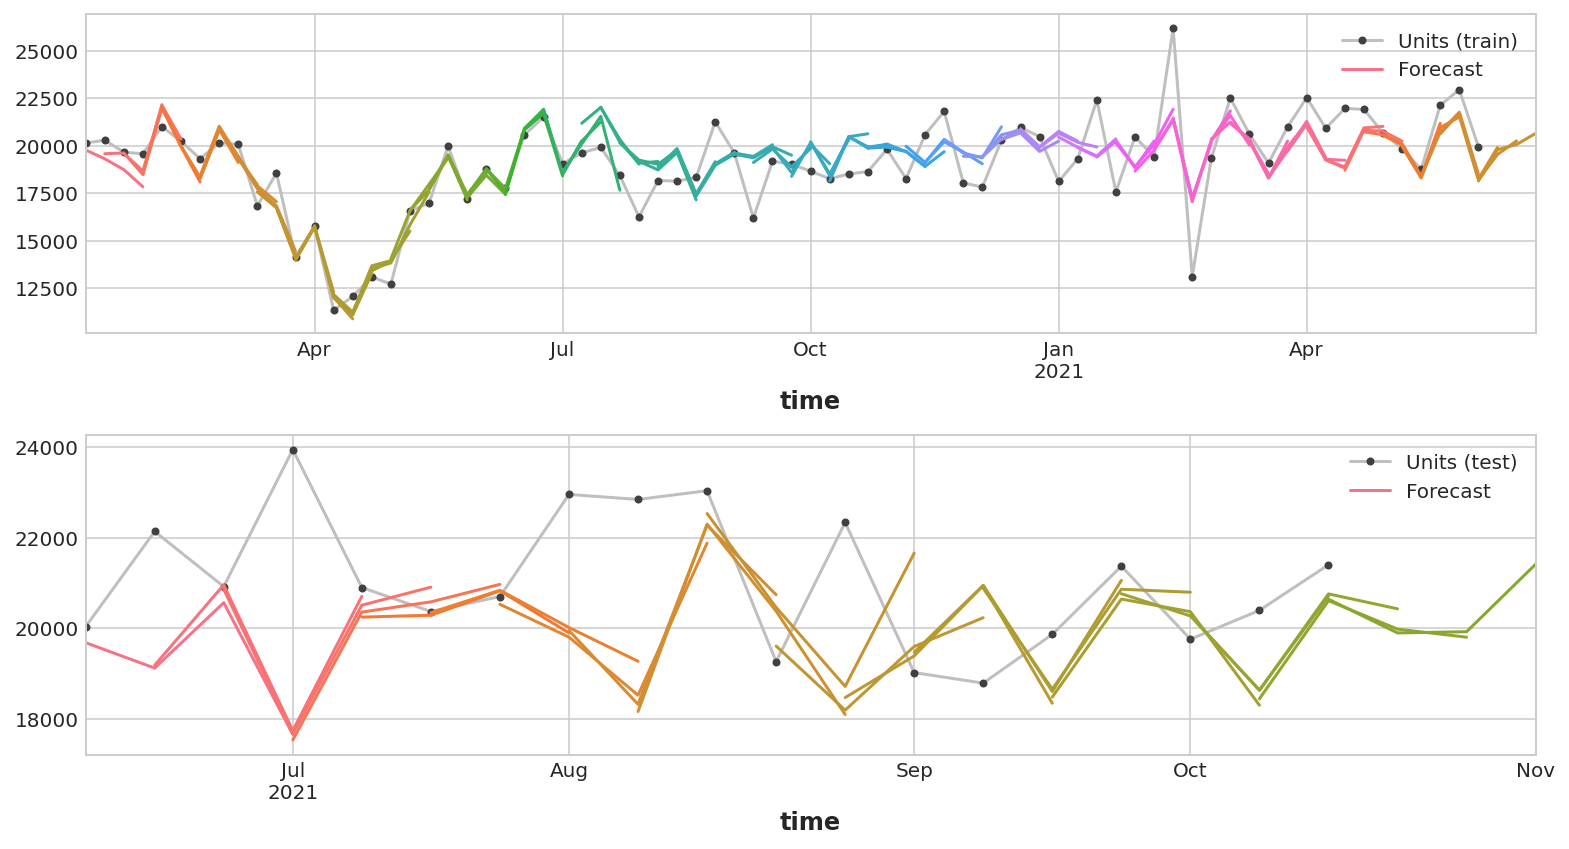

In [62]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df_kit.value[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Units (train)', 'Forecast'])
ax2 = df_kit.value[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Units (test)', 'Forecast'])

In [66]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 0.00
Test RMSE: 2298.70


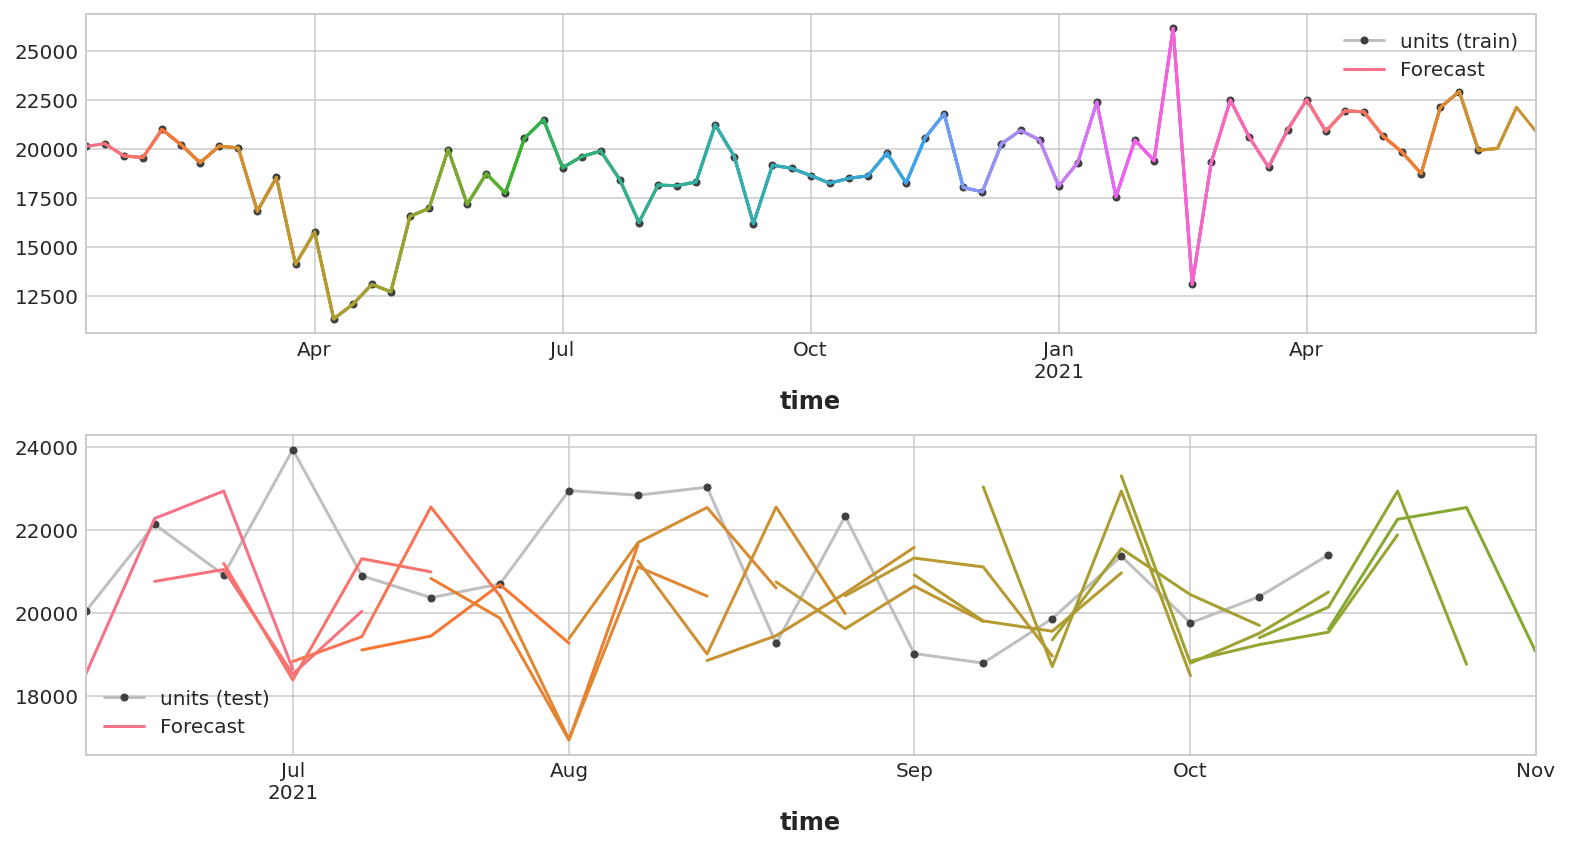

In [68]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = df_kit.value[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['units (train)', 'Forecast'])
ax2 = df_kit.value[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['units (test)', 'Forecast'])